In [45]:
import numpy as np
import pandas as pd
import os

from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder

mimic3_path = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir), 'data')

In [46]:
# preprocessing functions
# nan values are assigned the privileged class
def get_religion_category(religion):
    if (religion == "JEWISH") or (religion == "OTHER") or (religion == "BUDDHIST") or (religion == "MUSLIM") or (religion == "HINDU") or (religion == "HEBREW"):
        return 0  # unprivileged
    return 1  # privileged

def get_language_category(lang):
    if (lang == "ENGL") or pd.isna(lang):
        return 1  # privileged
    return 0  # unprivileged

def get_age(df):
    adm.ADMITTIME = pd.to_datetime(adm.ADMITTIME).dt.date
    adm.DOB = pd.to_datetime(adm.DOB).dt.date
    adm['AGE'] = adm.apply(lambda e:int((e.ADMITTIME - e.DOB).days/365.242), axis=1)
    adm.loc[adm.AGE <= 0, 'AGE'] = 90
    adm.loc[adm.AGE >= 300, 'AGE'] = 90
    return df

def get_age_category(age):
    if age<65 or pd.isna(age):
        return 1  # privileged <65 plus nans
    return 0  # unprivileged 65+

def get_insurance_category(insurance):
    # considers government insurance in unprivileged class
    # if insurance == "Private" or pd.isna(insurance):
    #     return 1  # privileged
    # return 0  # unprivileged

    # considers only uninsured in unprivileged class
    if insurance == "Self Pay":
        return 0
    return 1

def get_ethnicity_category(ethnicity):
    if ("WHITE" in ethnicity) or (pd.isna(ethnicity)):
        return 1  # privileged
    return 0  # unprivileged

In [47]:
patients = pd.read_csv(os.path.join(mimic3_path, 'PATIENTS.csv'))
adm = pd.read_csv(os.path.join(mimic3_path, 'ADMISSIONS.csv'))

In [48]:
# keep only necessary columns
patients = patients[['SUBJECT_ID', 'GENDER', 'DOB']]
adm = adm[['SUBJECT_ID', 'LANGUAGE', 'INSURANCE', 'RELIGION', 'ETHNICITY', 'ADMITTIME']]

In [49]:
patients.head(100)

,SUBJECT_ID,GENDER,DOB
0,249,F,2075-03-13 00:00:00
1,250,F,2164-12-27 00:00:00
2,251,M,2090-03-15 00:00:00
3,252,M,2078-03-06 00:00:00
4,253,F,2089-11-26 00:00:00
5,255,M,2109-08-05 00:00:00
6,256,M,2086-07-31 00:00:00
7,257,F,2031-04-03 00:00:00
8,258,F,2124-09-19 00:00:00
9,260,F,2105-03-23 00:00:00


In [50]:
adm.head(100)

,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,ADMITTIME
0,22,NaN,Private,UNOBTAINABLE,WHITE,2196-04-09 12:26:00
1,23,NaN,Medicare,CATHOLIC,WHITE,2153-09-03 07:15:00
2,23,ENGL,Medicare,CATHOLIC,WHITE,2157-10-18 19:34:00
3,24,NaN,Private,PROTESTANT QUAKER,WHITE,2139-06-06 16:14:00
4,25,NaN,Private,UNOBTAINABLE,WHITE,2160-11-02 02:06:00
5,26,NaN,Medicare,CATHOLIC,UNKNOWN/NOT SPECIFIED,2126-05-06 15:16:00
6,27,NaN,Private,CATHOLIC,WHITE,2191-11-30 22:16:00
7,28,NaN,Medicare,CATHOLIC,WHITE,2177-09-01 07:15:00
8,30,NaN,Medicare,CATHOLIC,UNKNOWN/NOT SPECIFIED,2172-10-14 14:17:00
9,31,NaN,Medicare,CATHOLIC,WHITE,2108-08-22 23:27:00


In [51]:
patients_original = patients.copy()
adm_original = adm.copy()

In [52]:
# merge the two tables
adm = adm.merge(patients, how='left', on='SUBJECT_ID')

In [71]:
print("Total Subjects: {}".format(len(adm.SUBJECT_ID.unique())))

Total Subjects: 46520


In [55]:
# preprocess religion to christian (majority religion) vs. non-christian
# unknown values get the majority class
print("Null Values: {} ({}%)".format(adm.RELIGION.isna().sum(), adm.RELIGION.isna().sum()/adm.shape[0]))
print("Distinct values: {}".format(len(adm.RELIGION.value_counts())))
print("Majority Class: {} ({}%) - Minority Class: {} ({}%)".format(
    adm.RELIGION.value_counts().keys()[0],
    adm.RELIGION.value_counts()[0]/adm.shape[0],
    adm.RELIGION.value_counts().keys()[-1],
    adm.RELIGION.value_counts()[-1]/adm.shape[0]
))
print("Original Religion Values:")
print(adm.RELIGION.value_counts())

Null Values: 458 (0.00776587086272382%)
Distinct values: 20
Majority Class: CATHOLIC (0.34939636462289747%) - Minority Class: LUTHERAN (1.695604991861096e-05%)
Original Religion Values:
CATHOLIC                  20606
NOT SPECIFIED             11753
UNOBTAINABLE               8269
PROTESTANT QUAKER          7134
JEWISH                     5314
OTHER                      2696
EPISCOPALIAN                774
GREEK ORTHODOX              459
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: RELIGION, dtype: int64


In [ ]:
print("Binarized Religion Values:")
adm.RELIGION = adm.RELIGION.apply(lambda religion: get_religion_category(religion))
print(adm.RELIGION.value_counts())

In [56]:
# preprocess language to english (majority speaking) vs. non-english
# unknown values get the majority class
print("Null Values: {} ({}%)".format(adm.LANGUAGE.isna().sum(), adm.LANGUAGE.isna().sum()/adm.shape[0]))
print("Distinct values: {}".format(len(adm.LANGUAGE.value_counts())))
print("Majority Class: {} ({}%) - Minority Class: {} ({}%)".format(
    adm.LANGUAGE.value_counts().keys()[0],
    adm.LANGUAGE.value_counts()[0]/adm.shape[0],
    adm.LANGUAGE.value_counts().keys()[-1],
    adm.LANGUAGE.value_counts()[-1]/adm.shape[0]
))
print("Original Language Values:")
print(adm.LANGUAGE.value_counts())

Null Values: 25332 (0.42953065653825284%)
Distinct values: 75
Majority Class: ENGL (0.4931836679327184%) - Minority Class: *ROM (1.695604991861096e-05%)
Original Language Values:
ENGL    29086
SPAN     1083
RUSS      790
PTUN      628
CANT      413
PORT      342
CAPE      256
MAND      156
HAIT      150
ITAL      124
VIET       94
GREE       75
ARAB       47
PERS       44
CAMB       37
POLI       34
AMER       31
HIND       24
KORE       23
ALBA       17
FREN       16
SOMA       13
THAI       12
ETHI       11
*ARM        9
*GUJ        7
*CHI        7
*BEN        7
LAOT        7
*YID        7
        ...  
* BE        2
**SH        2
*LEB        2
*KHM        2
BENG        2
*DUT        2
*TOI        2
*FUL        2
*AMH        2
*CAN        2
*BOS        1
*TAM        1
*SPA        1
*LIT        1
*NEP        1
* FU        1
** T        1
*FAR        1
*PHI        1
*YOR        1
GERM        1
*CRE        1
*RUS        1
*PER        1
*FIL        1
*DEA        1
SERB        1
*PUN     

In [218]:
print("Binarized Language Values:")
adm.LANGUAGE =adm.LANGUAGE.apply(lambda lang: get_language_category(lang))
print(adm.LANGUAGE.value_counts())

Original Language Values:
ENGL    29086
SPAN     1083
RUSS      790
PTUN      628
CANT      413
        ...  
* FU        1
*SPA        1
*RUS        1
*ROM        1
*TAM        1
Name: LANGUAGE, Length: 75, dtype: int64
Binarized Language Values:
1    54418
0     4558
Name: LANGUAGE, dtype: int64


Null Values: 0 (0.0%)
Distinct values: 77
Original Age Values:
90    10726
78     1139
77     1115
69     1096
61     1086
76     1086
66     1084
68     1082
62     1075
75     1074
64     1064
80     1052
79     1046
81     1045
72     1043
65     1043
67     1041
63     1033
74     1027
60     1025
58     1012
71     1008
57      985
59      983
83      970
73      962
70      962
84      958
82      935
55      915
      ...  
42      448
41      401
40      397
39      385
38      332
37      324
34      275
36      264
35      258
33      253
32      227
28      218
22      217
24      216
21      213
23      209
25      209
26      206
31      198
30      197
29      196
20      192
27      175
19      156
18      134
17       69
16       23
15        8
14        1
89        1
Name: AGE, Length: 77, dtype: int64
Binarized Age Values:
0    34156
1    24820
Name: AGE, dtype: int64


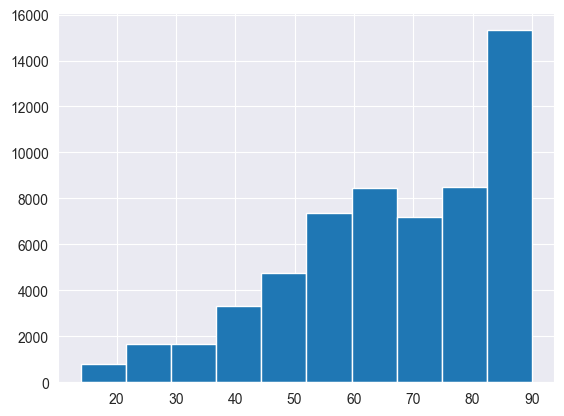

In [62]:
# preprocess age to 65+ (minority) vs younger
adm = get_age(adm)
plt.hist(adm.AGE)
print("Null Values: {} ({}%)".format(adm.AGE.isna().sum(), adm.AGE.isna().sum()/adm.shape[0]))
print("Distinct values: {}".format(len(adm.AGE.value_counts())))
print("Original Age Values:")
print(adm.AGE.value_counts())
adm.AGE =adm.AGE.apply(lambda age: get_age_category(age))
print("Binarized Age Values:")
print(adm.AGE.value_counts())

In [63]:
print("Null Values: {} ({}%)".format(adm.AGE.isna().sum(), adm.AGE.isna().sum()/adm.shape[0]))
print("Distinct values: {}".format(len(adm.AGE.value_counts())))
# print("Majority Class: {} ({}%) - Minority Class: {} ({}%)".format(
#     adm.AGE.value_counts().keys()[0],
#     adm.AGE.value_counts()[0]/adm.shape[0],
#     adm.AGE.value_counts().keys()[-1],
#     adm.AGE.value_counts()[-1]/adm.shape[0]
# ))

Null Values: 0 (0.0%)
Distinct values: 2


In [67]:
print("Original Insurance Values:")
print(adm.INSURANCE.value_counts())
print(adm.INSURANCE.value_counts())
print("Null Values: {} ({}%)".format(adm.INSURANCE.isna().sum(), adm.GENDER.isna().sum() / adm.shape[0]))
print("Distinct values: {}".format(len(adm.INSURANCE.value_counts())))
print("Majority Class: {} ({}%) - Minority Class: {} ({}%)".format(
    adm.INSURANCE.value_counts().keys()[0],
    adm.INSURANCE.value_counts()[0] / adm.shape[0],
    adm.INSURANCE.value_counts().keys()[-1],
    adm.INSURANCE.value_counts()[-1] / adm.shape[0]
))

Original Insurance Values:
Medicare      28215
Private       22582
Medicaid       5785
Government     1783
Self Pay        611
Name: INSURANCE, dtype: int64
Medicare      28215
Private       22582
Medicaid       5785
Government     1783
Self Pay        611
Name: INSURANCE, dtype: int64
Null Values: 0 (0.0%)
Distinct values: 5
Majority Class: Medicare (0.47841494845360827%) - Minority Class: Self Pay (0.010360146500271297%)


In [220]:
adm.INSURANCE =adm.INSURANCE.apply(lambda insurance: get_insurance_category(insurance))
print("Binarized Insurance Values:")
print(adm.INSURANCE.value_counts())

Original Insurance Values:
Medicare      28215
Private       22582
Medicaid       5785
Government     1783
Self Pay        611
Name: INSURANCE, dtype: int64
Binarized Insurance Values:
1    58365
0      611
Name: INSURANCE, dtype: int64


In [65]:
print("Original Ethnicity Values:")
print(adm.ETHNICITY.value_counts())
print("Null Values: {} ({}%)".format(adm.ETHNICITY.isna().sum(), adm.ETHNICITY.isna().sum()/adm.shape[0]))
print("Distinct values: {}".format(len(adm.ETHNICITY.value_counts())))
print("Majority Class: {} ({}%) - Minority Class: {} ({}%)".format(
    adm.ETHNICITY.value_counts().keys()[0],
    adm.ETHNICITY.value_counts()[0]/adm.shape[0],
    adm.ETHNICITY.value_counts().keys()[-1],
    adm.ETHNICITY.value_counts()[-1]/adm.shape[0]
))

Original Ethnicity Values:
WHITE                                                       40996
BLACK/AFRICAN AMERICAN                                       5440
UNKNOWN/NOT SPECIFIED                                        4523
HISPANIC OR LATINO                                           1696
OTHER                                                        1512
ASIAN                                                        1509
UNABLE TO OBTAIN                                              814
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                             

In [221]:
adm.ETHNICITY =adm.ETHNICITY.apply(lambda ethnicity: get_ethnicity_category(ethnicity))
print("Binarized Ethnicity Values:")
print(adm.ETHNICITY.value_counts())

Original Ethnicity Values:
WHITE                                                       40996
BLACK/AFRICAN AMERICAN                                       5440
UNKNOWN/NOT SPECIFIED                                        4523
HISPANIC OR LATINO                                           1696
OTHER                                                        1512
ASIAN                                                        1509
UNABLE TO OBTAIN                                              814
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                             

In [66]:
print("Null Values: {} ({}%)".format(adm.GENDER.isna().sum(), adm.GENDER.isna().sum()/adm.shape[0]))
print("Distinct values: {}".format(len(adm.GENDER.value_counts())))
print("Majority Class: {} ({}%) - Minority Class: {} ({}%)".format(
    adm.GENDER.value_counts().keys()[0],
    adm.GENDER.value_counts()[0]/adm.shape[0],
    adm.GENDER.value_counts().keys()[-1],
    adm.GENDER.value_counts()[-1]/adm.shape[0]
))

Null Values: 0 (0.0%)
Distinct values: 2
Majority Class: M (0.5587018448182312%) - Minority Class: F (0.44129815518176885%)


In [222]:
adm.GENDER = adm.GENDER.apply(lambda gender: 0 if gender == "F" else 1)

In [223]:
adm.drop(['ADMITTIME', 'DOB'], axis=1, inplace=True)
print("Records w/ duplicates per user: {}".format(adm.shape[0]))
adm.drop_duplicates(subset=['SUBJECT_ID'], keep='last', inplace=True)  # keep the latest demographics per user
print("Records w/0 duplicates per user: {}".format(adm.shape[0]))

Records w/ duplicates per user: 58976
Records w/0 duplicates per user: 46520


In [224]:
adm.head(100)

,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE
0,22,1,1,1,1,0,1
2,23,1,1,1,1,1,0
3,24,1,1,1,1,1,1
4,25,1,1,1,1,1,1
5,26,1,1,1,0,1,0
...,...,...,...,...,...,...,...
116,107,1,1,1,0,1,0
117,108,1,1,1,1,1,0
131,125,0,1,1,0,0,1
132,126,1,1,1,1,0,0


In [225]:
adm.to_csv(os.path.join(mimic3_path, 'DEMOGRAPHICS.csv'), index=False)
print("Demographics file saved at: {}".format(os.path.join(mimic3_path, 'DEMOGRAPHICS.csv')))

Demographics file saved at: C:\Users\Sofia\PycharmProjects\mimic3-benchmarks\data\DEMOGRAPHICS.csv
